In [1]:
# Import numpy and matplotlib, and use jupyter magic to
# get plots directly in notebook
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from numba import jit

# Progress bar
from tqdm import trange

# Load line profiler
%load_ext line_profiler

## Curve fitting

It is quite often useful to determine the paramaters of some function that best fits a set of data. We will look briefly at a simple option in Python: `scipy.optimize.curve_fit`, which uses non-linear least squares, and is very easy to use and quite handy in many cases. See documentation for details: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

See also `scipy.optimize` more generally, as there are lots of different methods available: https://docs.scipy.org/doc/scipy/reference/optimize.html

In [2]:
## Example using scipy.curve_fit, which uses 
from scipy.optimize import curve_fit

Fitted parameters:  [0.79851674 0.66372142 0.28184387]


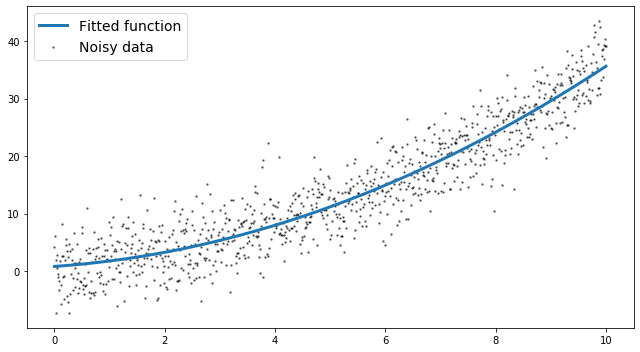

In [3]:
# Define a function to be fitted to the data.
# The first argument must be the variable,
# the other arguments are the parameters to be fitted
def f(x, a, b, c):
    return a + b*x + c*x**2

# Generate some data from the function, with noise
a, b, c = 1, 0.5, 0.3
N = 1000
x = np.linspace(0, 10, N)
y = f(x, a, b, c) + np.random.normal(loc = 0, scale = 4, size = N)

# Fit parameters.
# popt is a tuple of the N model parameters,
# pcov is a NxN covariance matrix.
# See documentation for details.
popt, pcov = curve_fit(f, x, y)

# Plot results, scatter plotting the data
# and drawing the fitted function on top
fig = plt.figure(figsize = (9, 5))
plt.scatter(x, y, s = 2, c = 'k', alpha = 0.5, label = 'Noisy data')
plt.plot(x, f(x, *popt), lw = 3, label = 'Fitted function')
plt.legend(fontsize = 14)
plt.tight_layout()

print('Fitted parameters: ', popt)

## Simulated annealing

An example of solving the Travelling Salesman Problem.

See https://en.wikipedia.org/wiki/Travelling_salesman_problem for more details.

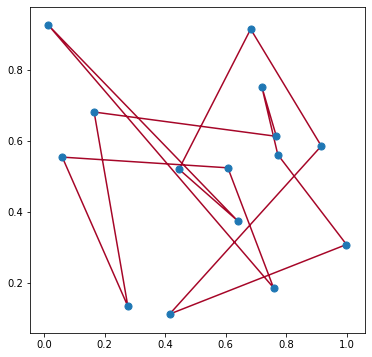

In [4]:
# Convenience function to visualise a tour
# Assumes tour is given by a 2 x N array of coordinates
def draw(tour, ax = None):
    if ax is None:
        fig, ax = plt.subplots(1, figsize = (6,6))
    ax.scatter(tour[0,:], tour[1,:], marker = 'o', s = 50, zorder = 2)
    # Create closed loop and plot
    ax.plot(list(tour[0,:]) + [tour[0,0]], list(tour[1,:]) + [tour[1,0]], color = '#A60628', zorder = 0)


# Create a list of 15 points. The ``tour'' is given
# by the order in which they appear in the array.
N =  15
cities = np.random.random((2, N))
draw(cities)

In [5]:
# Function to calculate the length of a tour
# Assumes tour is given by a 2 x N array of coordinates
# Profiling indicated that this function takes the most time,
# so compiling with numba
@jit(nopython = True)
def length(tour):
    dist = 0
    for i in range(tour.shape[1]):
        # Start at i-1 to close the loop, since i=0 at first iteration
        dist += np.sqrt((tour[0,i-1]-tour[0,i])**2 + (tour[1,i-1]-tour[1,i])**2)
    return dist

# Calling function once to force compilation here
_ = length(np.random.random(size = (2,3)))

    
# Function to generate a random variation of a tour
# Assumes tour is given by a 2 x N array of coordinates
def neighbour(tour, start, stop):
    copy = tour.copy()
#    N = copy.shape[1]
#    start, stop = sorted(np.random.randint(0, N-1, size = 2))
    # Reverse order of elements between start and stop
    copy[0,start:stop] = copy[0,start:stop][::-1]
    copy[1,start:stop] = copy[1,start:stop][::-1]
    return copy

def run_annealing(cities):
    # Use simulated annealing to find a hopefully better solution
    alpha = 0.95
    Niter = 100
    T     = 10
    Tmin  = 1e-6
    lens  = [length(cities)]
    Ts    = [T]
    N = cities.shape[1]
    while T > Tmin:
        random_indices = np.random.randint(0, N-1, size = (2, Niter))
        for i in range(Niter):
            # Create random modification and calculate length of both
            new = neighbour(cities, *sorted(random_indices[:,i]))
            old_cost = length(cities)
            new_cost = length(new)
            # Acceptance probability
            ap = np.exp((old_cost - new_cost)/T)
            if ap > np.random.random():
                cities = new
            # Create lists for plotting
            lens.append(old_cost)
            Ts.append(T)
        # Decrease temperature
        T = T*alpha
    return cities, np.array(lens), np.array(Ts)

In [6]:
N = 100
cities = np.random.random((2, N))
tour, lengths, temperatures = run_annealing(cities)
#%lprun -f run_annealing tour, lengths, temperatures = run_annealing(cities)

/Users/torn/anaconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in exp


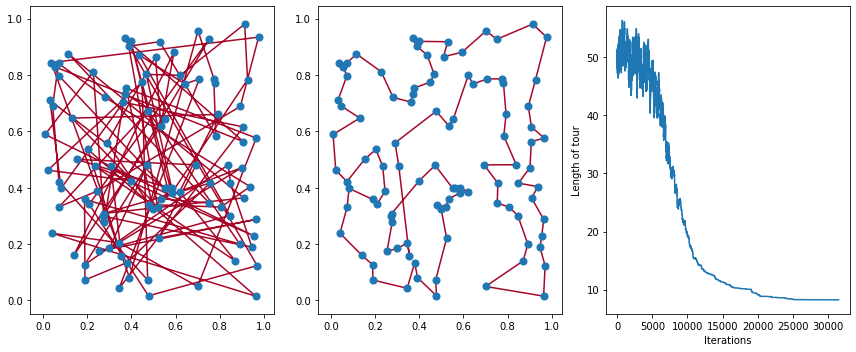

In [7]:
# Plot the tour that was found, and plot the development
# of the length as a function of iterations. Note how the
# length fluctuates in the beginning, and then tends to
# go more and more downwards as temperature decreases.
fig, ax = plt.subplots(ncols = 3, figsize = (12, 5))
draw(cities, ax = ax[0])
draw(tour, ax = ax[1])
ax[2].plot(lengths)
#ax[2].set_xscale('log')
ax[2].set_ylabel('Length of tour')
ax[2].set_xlabel('Iterations')
plt.tight_layout()

## Genetic algorithms

Genetic algorithms are a type of evolutionary algorithm where the idea is to encode the solution to some problem as a "genome", and then run a process that approximates some aspects of natural selection:
* Create a population of random solutions ("individuals")
* Run through a series of iterations (generations) with these steps:
 * Optionally copy the best few individuals unchanged into the next generation ("elitism")
 * Create a new population, based on combining the "genomes" of the best "individuals" ("crossover")
 * Randomly mutate a few of the individuals ("mutation")

Below we show an example of using Genetic Algorithms to find approximate solutions to the Travelling Salesman Problem. This problem is quite well suited, in that the order of the cities lends itself very naturally to be described by a "genome".

![illustration of crossover](fig/crossover.png)

See for example https://en.wikipedia.org/wiki/Genetic_algorithm for more information.

In [8]:
# This type of approach lends itself well to an object oriented implementation.
@jit(nopython = True)
def length(X, order):
    dist = 0
    for i in range(len(order)):
        dist += np.sqrt(np.sum((X[:,order[i]] - X[:,order[i-1]])**2))
    return dist


# For whatever reason, expressions like 'a in b' where
# b is an array doesn't seem to work with numba,
# so implementing that separately
# See https://stackoverflow.com/questions/54930852/python-numba-value-in-array/
@jit(nopython = True)
def is_in(val, arr):
    for i in range(len(arr)):
        if arr[i] == val:
            return True
    return False

@jit(nopython = True)
def crossover(order1, order2):
    # Create one new offspring by selecting a random
    # sequence from order1, then insert the missing cities
    # in the order they appear in order2
    N = order1.size
    new_order = -1*np.ones(N, dtype = np.int32)
    a, b = sorted(np.random.randint(0, N-1, size = 2))
    new_order[a:b] = order1[a:b]
    j = 0
    for i in range(N):
        if new_order[i] == -1:
            while is_in(order2[j], new_order):
                j += 1
            new_order[i] = order2[j]
    return new_order


# A class to hold a list of cities (x and y positions)
class Cities():
    pass

    def __init__(self, N):
        self.N = N
        self.X = np.random.random((2, N))


# A class to hold one realisation of a tour of all cities
# It stores the positions of the cities, and in a separate
# list the order in which the are to be visited.
class Tour():
    pass

    def __init__(self, cities, order = None):
        self.cities = cities
        self.N      = cities.X.shape[1]
        if order is None:
            self.order = np.arange(self.N)
            np.random.shuffle(self.order)
        else:
            self.order = order
        # Update the stored length
        self.update_length()
    
    # Implement __lt__ to be able to compare two tours
    # and to sort a list of tours.
    def __lt__(self, other):
        return self.length < other.length
    
    # Function to return the length of the tour
    # We typically need to evaluate each tour several times
    # for each generation, so we save time by storing the result
    # instead of computing it every time.
    def update_length(self):
        # Store the length
        self.length = length(self.cities.X, self.order)

    # Convenience function to visualise a tour
    def draw(self, ax = None):
        if ax is None:
            fig = plt.figure(figsize = (6,6))
            ax  = fig.add_subplot(111, aspect = 'equal')
        for i in range(self.N):
            X1 = self.cities.X[:,self.order[i-1]]
            X2 = self.cities.X[:,self.order[i]]
            ax.plot([X1[0], X2[0]], [X1[1], X2[1]], zorder = 1, color = '#348ABD', lw = 1 )
            ax.scatter(X1[0], X1[1], zorder = 2, color = '#A60628')
            
    # Randomly switch two cities
#    def mutate(self):
#        # switch two random cities
#        # (randint is inclusive in the upper limit)
#        a, b = np.random.randint(0, self.N-1, size = 2)
#        self.order[a], self.order[b] = self.order[b], self.order[a]
#        # This changes the length of the tour,
#        # so we update the stored length.
#        self.update_length()
        
    # flip the order of a random subset
    def mutate(self):
        # switch two random cities
        # (randint is inclusive in the upper limit)
        a, b = sorted(np.random.randint(0, self.N-1, size = 2))
        self.order[a:b] = self.order[a:b][::-1]
        # This changes the length of the tour,
        # so we update the stored length.
        self.update_length()
        
    def crossover(self, other):
        # Create one offspring by selecting a random
        # sequence from self, then insert the missing cities
        # in the order they appear in the other.
        # Implementing the body of the function in a separate
        # numba-compiled function that takes the arrays as arguments.
        new_order = crossover(self.order, other.order)
        return Tour(self.cities, order = new_order)
    
# Class to store a collection of tours, and provide
# methods to do selection and evolution
class Population():

    def __init__(self, cities, Ntours, mutationrate=0.05, tournamentsize=10, elitism=2):
        self.cities = cities
        self.Ntours = Ntours
        self.tours  = np.zeros(Ntours, dtype = object)
        self.mutationrate = mutationrate
        self.tournamentsize = tournamentsize
        self.elitism = elitism
        for i in range(self.Ntours):
            # Fill population with random tours
            self.tours[i] = Tour(cities)
            
    # Function used to select "individuals" to create the next
    # generation. There are many variants of selection, but
    # tournament is common and easy to implement.
    def tournament(self):
        # Select self.tournamentsize random tours
        N = self.tournamentsize
        # Note that np.random.choice uses selection _with_ replacement
        # as default. It is possible to pass the keyword argument replace=False
        # but this takes longer to run, and since self.tours >> N, i settled
        # for the default behaviour.
        subset = np.random.choice(self.tours, size = N)
        # and return the best of those
        return sorted(subset)[0]
    
    # Takes the entire population one generation forwards.
    def evolve(self):
        # Array to hold the next generation
        new_tours = np.zeros(self.Ntours, dtype = object)
        # If elitism is active, the best e individuals are
        # copied directly into the next generation.
        e = self.elitism
        new_tours[:e] = sorted(self.tours)[:e]
        # Make up the reminder by combining two from the
        # previous generation into one new individual.
        for i in range(e, self.Ntours):
            tour1 = self.tournament()
            tour2 = self.tournament()
            new_tours[i] = tour1.crossover(tour2)
            # Randomly apply some mutation here and there
            if np.random.random() < self.mutationrate:
                new_tours[i].mutate()
        self.tours = new_tours
        
    def best(self):
        return sorted(self.tours)[0]
    
def run_evolution(cities, **kwargs):
    # Number of iterations (``generations'')
    Niter = 500
    # Population size
    Npop = 500
    pop = Population(cities, Npop, **kwargs)
    # Lists for plotting improvements
    lens = []
    for i in trange(Niter):
        pop.evolve()
        lens.append(pop.best().length)
    return pop, np.array(lens)

In [9]:
cities = Cities(100)

pop, lengths = run_evolution(cities, mutationrate = 0.1)

100%|██████████| 500/500 [00:28<00:00, 17.71it/s]


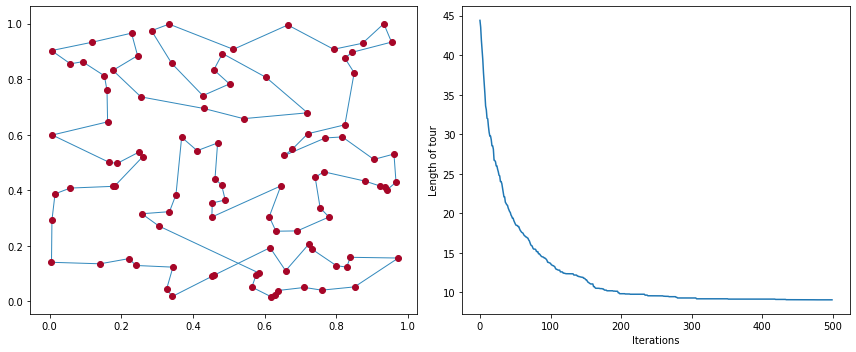

In [10]:
# Plot the tour that was found, and plot the development
# of the length as a function of iterations. Note how the
# length fluctuates in the beginning, and then tends to
# go more and more downwards as temperature decreases.
fig, ax = plt.subplots(ncols = 2, figsize = (12, 5))
pop.best().draw(ax = ax[0])
ax[1].plot(lengths)
#ax[2].set_xscale('log')
ax[1].set_ylabel('Length of tour')
ax[1].set_xlabel('Iterations')
plt.tight_layout()